![anatel](img/anatel_logo.png "Logo Anatel")
# <font color=green> Análise de Dados da Anatel em Minas Gerais (2015 - 2020) <font>

A Agência Nacional de Telecomunicaçõe ([Anatel](https://www.anatel.gov.br/institucional/)) foi criada em 16 de julho de 1997 com o objetivo de regular o setor de telecomunicações para contribuir com o desenvolvimento do Brasil.

Neste estudo iremos explorar o conjunto de dados das **Reclamações Registradas na Anatel** durante os anos de 2015 até 2020. Os dados foram baixados do  website [Dados Abertos](http://www.dados.gov.br/dataset/solicitacoesregistradasnaanatel) e o [Dicionário de Dados Oficial](data/Reclamações_Glossário_e_Metadados.pdf).

***
# <font color=green> Objetivo <font>

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados do conjunto **Reclamações Registradas na Anatel**; \
E também aperfeiçoar os estudos realizados em cima da biblioteca pyspark e matplotlib utilizando de despadronização das pesquisas para um melhor entendimento geral das ferramentas.

1. Principais reclamações
2. Quantidade de solicitações por Estado
3. Aprofudando nos 3 estados com mais solicitações
4. Porque são Paulo tão descrepante?
5. Principais problemas em São Paulo

***
# <font color=green> Metodologia <font>

| Coluna | Descrição |   
|---------|--------|
|DataExtracao|Data que foram extraídos os dados da base do sistema Anatel|
|Ano|Ano de registro da solicitação|
|Mes|Mês de registro da solicitação|
|CanalEntrada|Canal de atendimento usado para registrar a solicitação |
|Condicao|Informação da solicitação|
|GrupoEconNorm|Marcas a que se refere a solicitação.|
|TipoAtendimento |-------|
|Servico|Indica o serviço a que se refere a solicitação|
|Modalidade|Nível mais amplo do tema que estão atreladas as solicitações registradas|
|Motivo|Os motivos expressam a natureza das demandas com mais detalhes.|
|UF|Unidade da Federação – Estados, Territórios e Distrito Federal|
|SOLICITAÇÕES| quantidade de solicitações registradas na Anatel.|

# <font color=green> OBSERVAÇÕES <font>
<ul>
    <li>
        <code>Canal Entrada</code>: Os canais pelos quais a Anatel pode receber solicitações (Fale 
        Conosco, 1331, Aplicativo, etc.
    </li>
    <li>
        <code>Grupo Econômico</code>:
        Apesar de Claro e Net pertencerem ao mesmo grupo econômico, as marcas são distintas e, portanto, aparecem separadas.
    </li>
    <li>
        <code>tarifa</code>: Exemplos na tabela: Telefone Fixo, Banda Larga Fixa, TV por Assinatura e Celular Pré-Pago e Celular Pós-Pago
    </li>
    <li>
        <code>Condição</code>: Informa se a solicitação já foi reaberta
    </li>
    <ul>
        <li>
            <b>Nova</b>: Uma solicitação que, uma vez respondida, não foi reaberta pelo consumidor.
        </li>
        <li>
            <b>Reaberta</b>: O consumidor que não se sente satisfeito com a resposta dada a sua reclamação pode reabrir a solicitação para que a prestadora manifeste-se novamente.
        </li>
    </ul>
</ul>

## 1.1 Configuração do Ambiente

In [1]:
import os
import findspark
import zipfile
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, functions as f
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType,DoubleType,StringType

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))


## 1.2 Inicialização da Sessão Spark

In [2]:
os.environ["SPARK_HOME"] = 'C:\spark-3.2.0-bin-hadoop3.2'
findspark.init()
spark = SparkSession.builder.master('local[*]').getOrCreate()
spark

## 1.3 Leitura dos dados

In [3]:
arquivo = 'data/reclamacoes.csv'
if os.path.isfile(arquivo):
    print('O caminho {} existe'.format(arquivo))
else:
    zipfile.ZipFile('data/consumidor_reclamacoes.zip','r').extractall('data/')
    print('Os dados foram extraidos')
dados_brutos = spark.read.option("header","true").option("sep",";").csv(arquivo)

O caminho data/reclamacoes.csv existe


## 1.4 Organização e Limpeza dos Dados

### 1.4.1 Visão do Conjunto de Dados

In [4]:
dados_brutos.show(3, truncate = False)

+------------+------------+----+---+-------+---+----------+------------+------------+-------------+--------------------+-------+------+---------------------------------------------------+------------------------------------------+
|DataExtracao|SOLICITAÇÕES|Ano |Mês|AnoMês |UF |Cidade    |CO_MUNICIPIO|CanalEntrada|Condição     |TipoAtendimento     |Serviço|Marca |Assunto                                            |Problema                                  |
+------------+------------+----+---+-------+---+----------+------------+------------+-------------+--------------------+-------+------+---------------------------------------------------+------------------------------------------+
|2018-04-23  |1           |2015|1  |2015-01|DF |Brasília  |5300108     |SIC         |Reencaminhada|Pedido de Informação|Outros |Outros|NÃO APLICÁVEL                                      |SIC                                       |
|2018-04-23  |1           |2015|1  |2015-01|AC |Rio Branco|1200401     |Fale

#### 1.4.1.1 Tipos por coluna

In [5]:
dados_brutos.printSchema()

root
 |-- DataExtracao: string (nullable = true)
 |-- SOLICITAÇÕES: string (nullable = true)
 |-- Ano: string (nullable = true)
 |-- Mês: string (nullable = true)
 |-- AnoMês: string (nullable = true)
 |-- UF: string (nullable = true)
 |-- Cidade: string (nullable = true)
 |-- CO_MUNICIPIO: string (nullable = true)
 |-- CanalEntrada: string (nullable = true)
 |-- Condição: string (nullable = true)
 |-- TipoAtendimento: string (nullable = true)
 |-- Serviço: string (nullable = true)
 |-- Marca: string (nullable = true)
 |-- Assunto: string (nullable = true)
 |-- Problema: string (nullable = true)



#### 1.4.1.2 total de linhas e colunas

In [6]:
print("Linhas:{} | Colunas: {}".format(dados_brutos.count(),len(dados_brutos.columns)))

Linhas:15952407 | Colunas: 15


#### 1.4.1.3 Total de valores nulos por coluna

In [7]:
dados_brutos.select([f.count(f.when(f.isnull(c),1)).alias(c) for c in dados_brutos.columns]).show()

+------------+------------+---+---+------+---+------+------------+------------+--------+---------------+-------+-----+-------+--------+
|DataExtracao|SOLICITAÇÕES|Ano|Mês|AnoMês| UF|Cidade|CO_MUNICIPIO|CanalEntrada|Condição|TipoAtendimento|Serviço|Marca|Assunto|Problema|
+------------+------------+---+---+------+---+------+------------+------------+--------+---------------+-------+-----+-------+--------+
|           0|           0|  0|  0|     0| 63| 49897|           0|           0|       0|              0|      3|    3|      0|       0|
+------------+------------+---+---+------+---+------+------------+------------+--------+---------------+-------+-----+-------+--------+



### 1.4.2 Remoção de Colunas
Serão Excluidas as colunas `DataExtracao` | `AnoMês` | `CO_MUNICIPIO` | `Condição`

In [8]:
colunas_a_remover = ['DataExtracao','AnoMês','CO_MUNICIPIO','Condição']
df_anatel = dados_brutos.select([c for c in dados_brutos.columns if c not in colunas_a_remover])

### 1.4.3 Renomeando colunas
**Retirando acentuação gráfica, letras maiúsculas e padrão CamelCase no nome das colunas**

In [9]:
antigos_nomes = ['SOLICITAÇÕES','Ano',
               'Mês','Cidade','CanalEntrada',
               'TipoAtendimento','Serviço','Marca',
               'Assunto','Problema']

novos_nomes = ['solicitacoes','ano','mes',
               'cidade','canal_entrada','tipo_atendimento',
               'servico','marca','assunto','problema']

for antigo, novo in zip(antigos_nomes,novos_nomes):
    df_anatel = df_anatel.withColumnRenamed(antigo,novo)
df_anatel.show(0)

+------------+---+---+---+------+-------------+----------------+-------+-----+-------+--------+
|solicitacoes|ano|mes| UF|cidade|canal_entrada|tipo_atendimento|servico|marca|assunto|problema|
+------------+---+---+---+------+-------------+----------------+-------+-----+-------+--------+
+------------+---+---+---+------+-------------+----------------+-------+-----+-------+--------+
only showing top 0 rows



### 1.4.4 Conversão de tipos

In [10]:
df_anatel = df_anatel.withColumn('solicitacoes',df_anatel['solicitacoes'].cast(IntegerType()))\
.withColumn('ano',df_anatel['ano'].cast(IntegerType()))\
.withColumn('mes',df_anatel['mes'].cast(IntegerType()))

### 1.4.5 Dados Ausentes
**Os dados NULOS das colunas `UF`,`Cidades`,`Serviço`, `Marca` serão excluidos**

In [11]:
df_anatel = df_anatel.na.drop()

## 1.5 Mapeamento dos Dados
Para auxiliar na análise e interpretação os seguintes dados serão padronizados

| Coluna | Original | Modificado |   
|---------|--------|--------|
|tipo_atendimento|`Denúncia Anônima`,`Denúncia ANÔNIMA`|Denúncia Anônima|

In [12]:
df_anatel = df_anatel.withColumn('tipo_atendimento', f.regexp_replace('tipo_atendimento','Denúncia ANÔNIMA','Denúncia Anônima'))

# <font color=green>2 Análise Exploratória <font> 

In [13]:
def transformar_array(dados):
    _ = dados.collect()
    y = []
    x = []
    for item in _:
        x.append(item[0])
        y.append(item[1])
    return(x,y)

In [14]:
def imprimir_assunto():
    cobrancas_mais_frequentes = df_anatel.where(col('Assunto') == 'Cobrança')\
                            .groupBy('Problema').sum('solicitacoes')\
                            .orderBy('sum(solicitacoes)',ascending=False).limit(5)

    fig = plt.figure(figsize=(12,6))
    eixo = fig.add_axes([0,0,1,1])

    x,y = transformar_array(cobrancas_mais_frequentes)
    eixo.bar(x,y, color="#5464FF")

    eixo.set_ylabel('Número de Solicitações',fontsize=20)
    eixo.set_title('Top 5 solicitações do assunto cobrança', fontsize=25)

    contador = 0 
    for valores in cobrancas_mais_frequentes.collect():
        if(contador == 2):
            eixo.annotate(valores[:][0], 
            xy=(contador, valores[:][1]),
            xycoords='data',
            xytext=(contador*0.8, valores[:][1]+250000),
            textcoords='data',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
        else:
            eixo.annotate(valores[:][0], 
            xy=(contador, valores[:][1]),
            xycoords='data',
            xytext=(contador, valores[:][1]+150000),
            textcoords='data',
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
        contador += 1

    eixo.set_ylim(-1,2500000)
    plt.xticks(['.',''],None)

    plt.show()

## 2.1 Principais reclamações

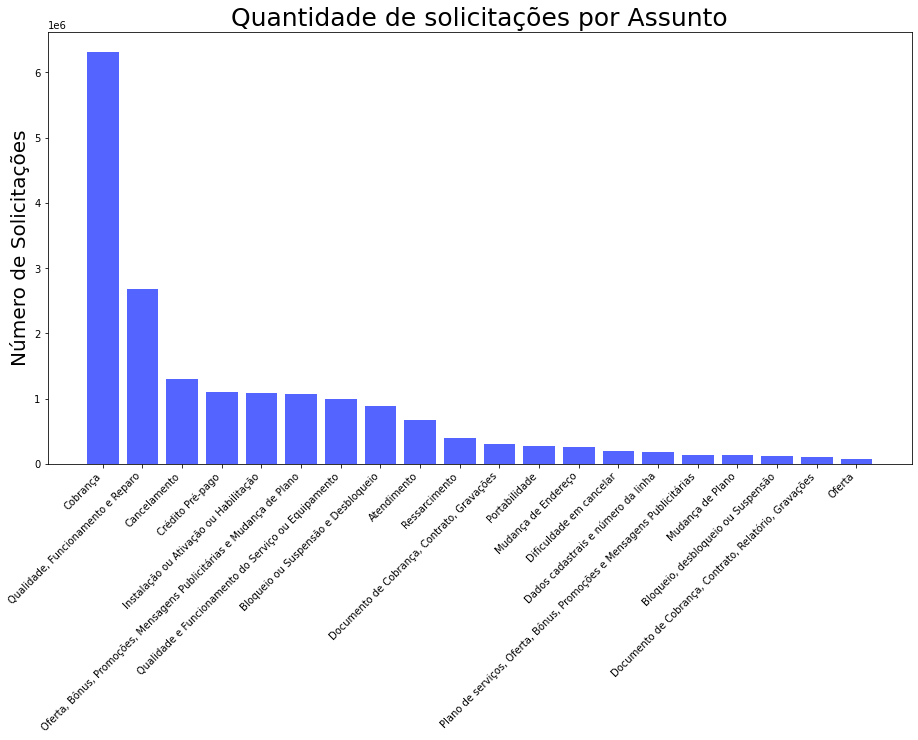

In [15]:
agrupamento_por_assunto = df_anatel.groupBy('Assunto').sum('solicitacoes').orderBy('sum(solicitacoes)',ascending=False).limit(20)

fig = plt.figure(figsize=(12,6))
eixo = fig.add_axes([0.2,0,1,1])

x,y =transformar_array(agrupamento_por_assunto)

eixo.bar(x, y, color="#5464FF")
eixo.locator_params(axis='y',nbins=11)

eixo.set_title('Quantidade de solicitações por Assunto', fontsize=25)
eixo.set_ylabel('Número de Solicitações',fontsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

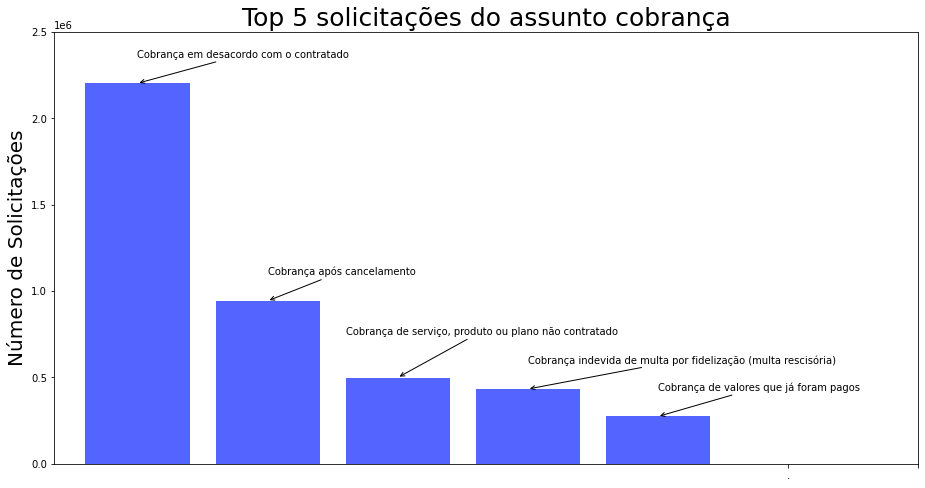

In [16]:
imprimir_assunto()

# 2.2 Quantidade de solicitações por Estado

Text(0.5, 0, 'Estados do Brasil')

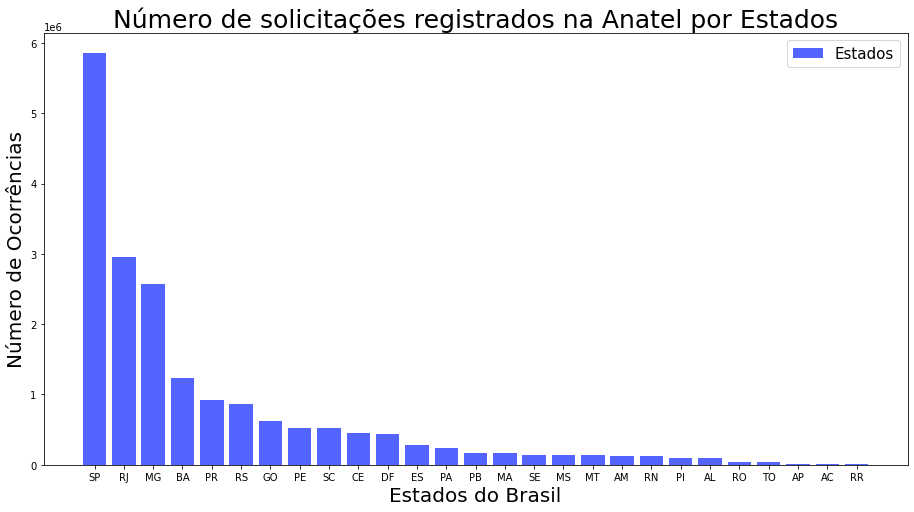

In [17]:
por_estado = df_anatel.groupBy("UF").sum("solicitacoes").withColumnRenamed("sum(solicitacoes)", "soma_solicitacoes")
por_estado = por_estado.orderBy("soma_solicitacoes",ascending=False)

fig = plt.figure(figsize=(12,6))
eixo = fig.add_axes([0.2,0,1,1])
x,y = transformar_array(por_estado)
eixo.bar(x, y,color="#5464FF")
eixo.legend(['Estados'],loc='upper right',fontsize=15)
eixo.locator_params(axis='y',nbins=11)
eixo.set_title('Número de solicitações registrados na Anatel por Estados', fontsize=25)
eixo.set_ylabel('Número de Ocorrências',fontsize=20)
eixo.set_xlabel('Estados do Brasil',fontsize=20)


## 2.2.1 Aprofudando nos 3 estados com mais solicitações

In [18]:
anos_sp = df_anatel.where(df_anatel.UF == 'SP').groupBy('Ano').agg(f.sum(col('solicitacoes'))).orderBy('Ano').withColumnRenamed("sum(solicitacoes)", "soma_solicitasoes").toPandas()
anos_rj = df_anatel.where(df_anatel.UF == 'RJ').groupBy('Ano').agg(f.sum(col('solicitacoes'))).orderBy('Ano').withColumnRenamed("sum(solicitacoes)", "soma_solicitasoes").toPandas()
anos_mg = df_anatel.where(df_anatel.UF == 'MG').groupBy('Ano').agg(f.sum(col('solicitacoes'))).orderBy('Ano').withColumnRenamed("sum(solicitacoes)", "soma_solicitasoes").toPandas()

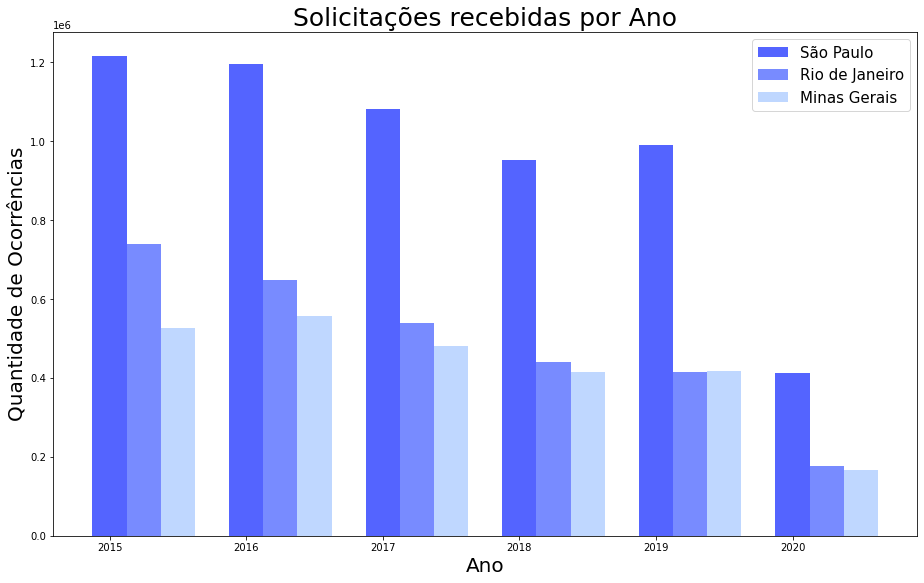

In [19]:
fig = plt.figure(figsize=(12,7))
eixo = fig.add_axes([0,0,1,1])

cores = {'São Paulo': '#5464FF', 'Rio de Janeiro': '#788BFF', 'Minas Gerais': '#Bfd7ff'}

x = anos_sp.Ano.values
y = [anos_sp.soma_solicitasoes, anos_rj.soma_solicitasoes ,anos_mg.soma_solicitasoes]

eixo.bar(x+0.00,y[0],color="#5464FF",width = 0.25)
eixo.bar(x+0.25,y[1],color="#788BFF",width = 0.25)
eixo.bar(x+0.50,y[2],color="#Bfd7ff",width = 0.25)

eixo.set_title('Solicitações recebidas por Ano', fontsize=25)
eixo.set_ylabel('Quantidade de Ocorrências',fontsize=20)
eixo.set_xlabel('Ano',fontsize=20)
eixo.legend(cores,loc='upper right',fontsize=15)

plt.show()

## 2.2.2 Porque são Paulo tão descrepante?

São Paulo em comparação populacional com Rio de Janeiro e Minas Gerais


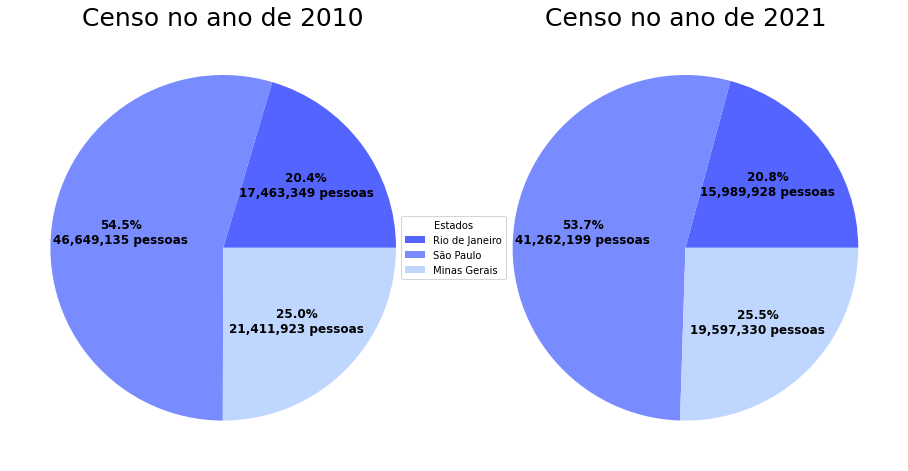

In [20]:
fig = plt.figure(figsize=(6,7))
eixo = fig.add_axes([0,0,1,1])
eixo_2 = fig.add_axes([1.07,0,1,1])

censo_2010,censo_2021 = [ 17463349,46649132, 21411923],[15989929,41262199, 19597330]
cores = ['#5464FF','#788BFF','#Bfd7ff']

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:,} pessoas".format(pct, absolute)

wedges, texts, textos_internos = eixo.pie(censo_2010,colors=cores, autopct=lambda pct: func(pct, censo_2010),textprops=dict(color="k"))
wedges2, texts2, textos_internos2 = eixo_2.pie(censo_2021,colors=cores, autopct=lambda pct: func(pct, censo_2021),textprops=dict(color="k"))

eixo.legend(wedges, ['Rio de Janeiro','São Paulo', 'Minas Gerais'],title="Estados",loc="center left",bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.setp(textos_internos, size=12, weight="bold")
plt.setp(textos_internos2, size=12, weight="bold")

eixo.set_title("Censo no ano de 2010",fontsize=25)
eixo_2.set_title("Censo no ano de 2021",fontsize=25)

print('São Paulo em comparação populacional com Rio de Janeiro e Minas Gerais')
plt.show()

Segundo os dados no site da [IBGE](https://cidades.ibge.gov.br/brasil/panorama):\
 **[São Paulo](https://cidades.ibge.gov.br/brasil/sp/panorama)**  contém uma população em cerca de 54% maior que 
 **[Rio de Janeiro](https://cidades.ibge.gov.br/brasil/rj/panorama)** e
 **[Minas Gerais](https://cidades.ibge.gov.br/brasil/mg/panorama)**
 
O número de Solicitações registradas pela ANATEL em São Paulo está ligada a quantidade de pessoas que habita o estado

# 2.2.3 Principais problemas em São Paulo

In [21]:
reclamacoes_sp = df_anatel.where((df_anatel.UF == 'SP') &(df_anatel.tipo_atendimento == 'Reclamação')).groupBy('Problema').sum('Solicitacoes').withColumnRenamed("sum(Solicitacoes)",'total_solicitacoes').orderBy('total_solicitacoes', ascending=False)
total = reclamacoes_sp.groupBy().sum().collect()[0][0]
reclamacoes_sp = reclamacoes_sp.limit(3)

In [22]:
reclamacoes_sp.withColumn("porcentagem_solicitacoes", f.round(col("total_solicitacoes")*100/total,2)).toPandas()

,Problema,total_solicitacoes,porcentagem_solicitacoes
0,Cobrança em desacordo com o contratado,620143,10.72
1,Cobrança após cancelamento,339825,5.88
2,"Cobrança de serviço, produto ou plano não cont...",214735,3.71
